# Spectral Analysis for paper

To-Do:
    - Calculate information flux plots...
    - Add Thorium backgrounds (once I've emailed asking about them)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from tqdm import tqdm
import swordfish as sf
from WIMpy import DMUtils as DMU
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz, quad
from scipy.special import erf
from paleo.paleopy_classes import *
import paleo.paleopy as paleopy

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=16)
#mpl.rcParams.update({'font.size': 16,'font.family':'serif'})

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

#%matplotlib inline

#### Load in the relevant rocks

In [2]:
Zab = Mineral("Zabuyelite")
Syl = Mineral("Sylvanite")
Sinj = Mineral("Sinjarite")
Oliv = Mineral("Olivine")

#### Calculating signal and background bins for a given mineral

In [55]:
N_BG_1nm = paleopy.GetBackground(Zab, 1.0)
N_BG_15nm = paleopy.GetBackground(Zab, 15.0)

/Users/bradkav/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


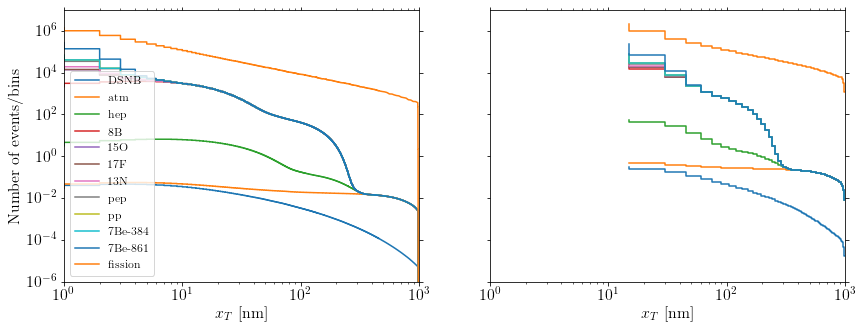

In [57]:
bkg_list = ['DSNB', 'atm', 'hep', '8B', '15O', '17F', '13N', 'pep','pp','7Be-384','7Be-861', 'fission']

f, axarr = plt.subplots(figsize=(14,5), nrows=1, ncols=2, sharey=True)

ax1, ax2 = axarr

ax1.set_xscale("log")
ax1.set_yscale("log")

for i,bkg in enumerate(bkg_list):
    ax1.step(paleopy.calcBins(1.0)[:-1] + 0.5, N_BG_1nm[i], label=bkg)

ax1.legend(fontsize=12)
ax1.set_ylim(1e-6, 1e7)
ax1.set_xlim(1, 1000)

ax1.set_ylabel(r"Number of events/bins")
ax1.set_xlabel(r"$x_T$ [nm]")

#------------------

ax2.set_xscale("log")
ax2.set_yscale("log")

for i,bkg in enumerate(bkg_list):
    ax2.step(paleopy.calcBins(15.0)[:-1] + 15.0/2, N_BG_15nm[i], label=bkg)

ax2.set_ylim(1e-6, 1e7)
ax2.set_xlim(1, 1000)
    
ax2.set_xlabel(r"$x_T$ [nm]")
    
#ax2.legend()
#ax2.legend(fontsize=12)

#f.subplots_adjust(hspace=0.001)

plt.show()

#### Calculating limits and discovery reaches

In [58]:
def GetLimitandDR(mineral, sigma, exposure, mlist):
    ref_sig = 1e-47
    systematics = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-3]

    limit_list = np.zeros_like(mlist)
    DR_list = np.zeros_like(mlist)

    dRdx_BG = paleopy.GetBackground(mineral, sigma)
    
    for i, m in enumerate(mlist):
        SF = sf.Swordfish(dRdx_BG, T=systematics, E=np.ones_like(dRdx_BG[0])*exposure)
        sig = paleopy.GetSignal(mineral, sigma, m_DM=m, xsec=ref_sig)
        UL = SF.upperlimit(sig, 0.05)
        DR = SF.discoveryreach(sig, 2.87e-7)
        limit_list[i] = ref_sig * UL
        DR_list[i] = ref_sig * DR
        
    np.savetxt('../ES/limits/lims_' + mineral.shortname +  '_exp' + str(exposure) + '_res' + str(sigma) + '.txt', list(zip(mlist, limit_list, DR_list)),
                header="Mineral: " + mineral.name + "; Exposure [kg Myr]: " + str(exposure) + "; sigma [nm]:" + str(sigma) + "\nColumns: m [GeV], 95% upper limit [cm^2], 5-sig discovery reach [cm^2]")
    return limit_list, DR_list

In [63]:
mlist = np.logspace(-0.5,4,num=100)

for mineral in [Syl, Zab, Sinj, Oliv]:
    print("Calculating for " + mineral.name + "...")
    lim, dr = GetLimitandDR(mineral, sigma=1.0, exposure=1.0, mlist=mlist)

Calculating for Sylvanite...


/Users/bradkav/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


KeyboardInterrupt: 

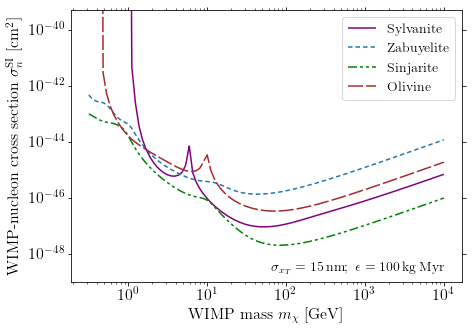

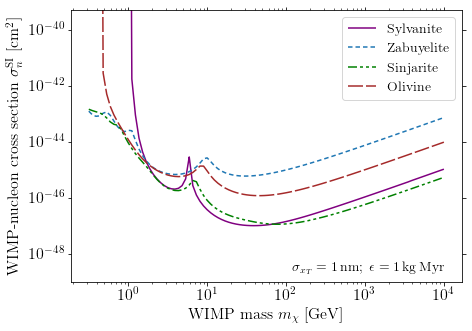

In [110]:
plt.figure(figsize=(7,5))

colors = ['Purple','C0', 'g', 'Brown']

dashes=[[3, 0],
        [3, 2],
        [6, 2, 2, 2,2,2],
        [10,2]]
          
for mineral,col,dash in zip([Syl, Zab, Sinj, Oliv],colors,dashes):
    mlist, lim, dr = np.loadtxt('../ES/limits/lims_' + mineral.shortname + '_exp1.0_res1.0.txt', unpack=True)
    plt.loglog(mlist, lim, label=mineral.name,color=col, dashes=dash)

plt.ylim(1e-49, 5e-40)
plt.yticks([1e-48, 1e-46, 1e-44, 1e-42, 1e-40])
    
    
plt.legend(fontsize=14)

plt.xlabel(r'WIMP mass $m_\chi$ [GeV]')
plt.ylabel(r'WIMP-nucleon cross section $\sigma_n^{\mathrm{SI}}$ [cm$^2$]')

plt.text(1e4, 2e-49, r'$\sigma_{x_T} = 1\,\mathrm{nm}; \,\,\epsilon = 1 \,\mathrm{kg}\,\mathrm{Myr}$', fontsize=14, ha='right')

plt.savefig('../plots/limits_exp1.0_sig1.0.pdf', bbox_inches="tight")

plt.show()

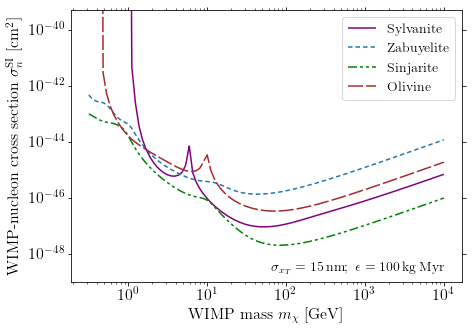

In [62]:
plt.figure(figsize=(7,5))

colors = ['Purple','C0', 'g', 'Brown']

dashes=[[3, 0],
        [3, 2],
        [6, 2, 2, 2,2,2],
        [10,2]]
          
for mineral,col,dash in zip([Syl, Zab, Sinj, Oliv],colors,dashes):
    mlist, lim, dr = np.loadtxt('../ES/limits/lims_' + mineral.shortname + '.txt', unpack=True)
    plt.loglog(mlist, lim, label=mineral.name,color=col, dashes=dash)

plt.ylim(1e-49, 5e-40)

plt.yticks([1e-48, 1e-46, 1e-44, 1e-42, 1e-40])
    
plt.legend(fontsize=14)

plt.xlabel(r'WIMP mass $m_\chi$ [GeV]')
plt.ylabel(r'WIMP-nucleon cross section $\sigma_n^{\mathrm{SI}}$ [cm$^2$]')

plt.text(1e4, 2e-49, r'$\sigma_{x_T} = 15\,\mathrm{nm}; \,\,\epsilon = 100 \,\mathrm{kg}\,\mathrm{Myr}$', fontsize=14, ha='right')

plt.savefig('../plots/limits_exp100.0_sig15.0.pdf', bbox_inches="tight")

plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


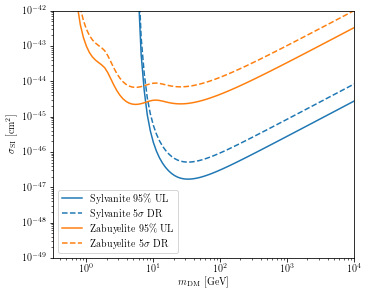

In [20]:
plt.figure(figsize=(5,4))
plt.loglog(mlist,Syl_limit, color='C0', linestyle='-', label=r'Sylvanite 95\% UL')
plt.loglog(mlist,Syl_DR, color='C0', linestyle='--', label=r'Sylvanite $5\sigma$ DR')
plt.loglog(mlist,Zab_limit, color='C1', linestyle='-', label=r'Zabuyelite 95\% UL')
plt.loglog(mlist,Zab_DR, color='C1', linestyle='--', label=r'Zabuyelite $5\sigma$ DR')
plt.ylabel(r'$\sigma_{\mathrm{SI}} ~[\mathrm{cm}^2]$')
plt.xlabel(r'$m_{\mathrm{DM}} ~[\mathrm{GeV}]$')
plt.xlim(10**(-0.5),1e4)
plt.ylim(1e-49,1e-42)
plt.legend()
plt.tight_layout(pad=0.3)
# plt.show()
plt.savefig("../plots/limits_nubkg_separate-10psys.pdf")